# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [4]:
train = np.ones((3, 4))

In [5]:
test = np.ones((2, 4))

In [6]:
train

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [7]:
train[:, None]

array([[[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]]])

In [8]:
train[:, None].shape

(3, 1, 4)

In [9]:
test[:, None].shape

(2, 1, 4)

In [10]:
(train[:, None] - test).shape

(3, 2, 4)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [12]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [13]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [15]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [16]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

probs: [0.57611688 0.21194156 0.21194156]
loss: 1.551444713932051
probs: [0.57611688 0.21194156 0.21194156]
loss: 1.551444713932051
probs: [0.57611444 0.21194278 0.21194278]
loss: 1.5514389527754138
probs: [0.57611933 0.21194034 0.21194034]
loss: 1.551450475113109
probs: [0.57611811 0.21193989 0.21194201]
loss: 1.5514525945248259
probs: [0.57611566 0.21194323 0.21194111]
loss: 1.5514368333559785
probs: [0.57611811 0.21194201 0.21193989]
loss: 1.551442594524826
probs: [0.57611566 0.21194111 0.21194323]
loss: 1.5514468333559783
Gradient check passed!


True

In [17]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

probs: [0.57611688 0.21194156 0.21194156]
loss: 1.551444713932051
probs: [0.57611688 0.21194156 0.21194156]
loss: 1.551444713932051
probs: [0.57611444 0.21194278 0.21194278]
loss: 1.5514389527754138
probs: [0.57611933 0.21194034 0.21194034]
loss: 1.551450475113109
probs: [0.57611811 0.21193989 0.21194201]
loss: 1.5514525945248259
probs: [0.57611566 0.21194323 0.21194111]
loss: 1.5514368333559785
probs: [0.57611811 0.21194201 0.21193989]
loss: 1.551442594524826
probs: [0.57611566 0.21194111 0.21194323]
loss: 1.5514468333559783
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [20]:
predictions.shape

(1, 4)

In [21]:
target_index.shape

(1, 1)

In [22]:
predictions.ndim

2

In [25]:
predictions

array([[ 1.,  2., -1.,  1.],
       [ 1.,  2., -1., -1.]])

In [27]:
m = np.max(predictions, axis=1)

In [28]:
m

array([2., 2.])

In [32]:
predictions -= m[:, None]

In [33]:
predictions

array([[-1.,  0., -3., -1.],
       [-1.,  0., -3., -3.]])

In [34]:
np.exp(predictions)

array([[0.36787944, 1.        , 0.04978707, 0.36787944],
       [0.36787944, 1.        , 0.04978707, 0.04978707]])

In [35]:
np.sum(predictions, axis=1)

array([-5., -7.])

In [38]:
predictions

array([[ 1.,  2., -1.,  1.],
       [ 1.,  2., -1., -1.]])

In [39]:
target_index

array([[2],
       [1]])

In [40]:
predictions[target_index]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [42]:
np.take(predictions, target_index)

array([[-1.],
       [ 2.]])

In [46]:
target_index

array([[2],
       [1]])

In [47]:
np.add(predictions, target_index, 1)

TypeError: return arrays must be of ArrayType

In [48]:
np.add.at(predictions, target_index, 1)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [58]:
predictions

array([[ 1.,  2., -1.,  1.],
       [ 1.,  2., -1., -1.]])

In [59]:
target_index

array([[2],
       [1]])

In [62]:
np.put_along_axis(predictions, target_index, 10, axis=1)

In [63]:
predictions

array([[ 1.,  2., 10.,  1.],
       [ 1., 10., -1., -1.]])

In [182]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

probs: [[0.20603191 0.56005279 0.02788339 0.20603191]]
loss: 3.5797242232074917
probs: [[0.20603027 0.56005395 0.02788344 0.20603233]]
loss: 3.5797221628965787
probs: [[0.20603355 0.56005164 0.02788333 0.20603148]]
loss: 3.5797262835347627
probs: [[0.20603306 0.56005033 0.02788354 0.20603306]]
loss: 3.579718622691863
probs: [[0.20603076 0.56005526 0.02788323 0.20603076]]
loss: 3.5797298237477597
probs: [[0.20603197 0.56005295 0.02788312 0.20603197]]
loss: 3.579733944374979
probs: [[0.20603185 0.56005264 0.02788366 0.20603185]]
loss: 3.5797145020427146
probs: [[0.20603233 0.56005395 0.02788344 0.20603027]]
loss: 3.5797221628965787
probs: [[0.20603148 0.56005164 0.02788333 0.20603355]]
loss: 3.5797262835347627
Gradient check passed!


True

In [190]:
# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

probs: [[0.29692274 0.29692274 0.10923177 0.29692274]
 [0.15216302 0.41362198 0.02059303 0.41362198]
 [0.3994863  0.3994863  0.1469628  0.05406459]]
loss: 5.014661918673797
probs: [[0.29692065 0.29692362 0.1092321  0.29692362]
 [0.15216302 0.41362198 0.02059303 0.41362198]
 [0.3994863  0.3994863  0.1469628  0.05406459]]
loss: 5.014658949456809
probs: [[0.29692483 0.29692186 0.10923145 0.29692186]
 [0.15216302 0.41362198 0.02059303 0.41362198]
 [0.3994863  0.3994863  0.1469628  0.05406459]]
loss: 5.014664887911659
probs: [[0.29692362 0.29692065 0.1092321  0.29692362]
 [0.15216302 0.41362198 0.02059303 0.41362198]
 [0.3994863  0.3994863  0.1469628  0.05406459]]
loss: 5.014658949456809
probs: [[0.29692186 0.29692483 0.10923145 0.29692186]
 [0.15216302 0.41362198 0.02059303 0.41362198]
 [0.3994863  0.3994863  0.1469628  0.05406459]]
loss: 5.014664887911659
probs: [[0.29692307 0.29692307 0.1092308  0.29692307]
 [0.15216302 0.41362198 0.02059303 0.41362198]
 [0.3994863  0.3994863  0.1469628 

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [195]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

probs: [[0.88079708 0.11920292]
 [0.04742587 0.95257413]]
loss: 2.1755153626167147
probs: [[0.88079708 0.11920292]
 [0.04742587 0.95257413]]
loss: 2.1755153626167147
probs: [[0.88079813 0.11920187]
 [0.04742587 0.95257413]]
loss: 2.175524170592744
probs: [[0.88079603 0.11920397]
 [0.04742587 0.95257413]]
loss: 2.1755065546511845
probs: [[0.88079603 0.11920397]
 [0.04742587 0.95257413]]
loss: 2.1755065546511845
probs: [[0.88079813 0.11920187]
 [0.04742587 0.95257413]]
loss: 2.175524170592744
probs: [[0.88079813 0.11920187]
 [0.04742542 0.95257458]]
loss: 2.1755236963362714
probs: [[0.88079603 0.11920397]
 [0.04742632 0.95257368]]
loss: 2.175507028912175
probs: [[0.88079603 0.11920397]
 [0.04742632 0.95257368]]
loss: 2.175507028912175
probs: [[0.88079813 0.11920187]
 [0.04742542 0.95257458]]
loss: 2.1755236963362714
probs: [[0.88079603 0.11920397]
 [0.04742542 0.95257458]]
loss: 2.1755060803947117
probs: [[0.88079813 0.11920187]
 [0.04742632 0.95257368]]
loss: 2.1755246448537346
probs: [

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [196]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [237]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 135.051445
Epoch 1, loss: 244.647198
Epoch 2, loss: 321.125156
Epoch 3, loss: 353.861300
Epoch 4, loss: 378.770278
Epoch 5, loss: 414.726590
Epoch 6, loss: 436.794349
Epoch 7, loss: 445.463482
Epoch 8, loss: 402.386398
Epoch 9, loss: 405.338735


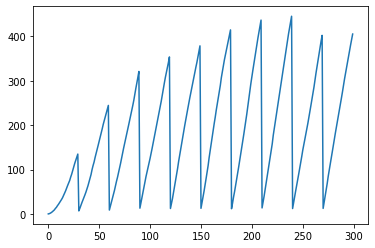

In [238]:
# let's look at the loss history!
plt.plot(loss_history)

In [239]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=5, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.162
Epoch 0, loss: 383.833143
Epoch 1, loss: 417.010872
Epoch 2, loss: 413.329045
Epoch 3, loss: 398.723558
Epoch 4, loss: 412.163163
Accuracy after training for 100 epochs:  0.181


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [240]:
%%time
from itertools import product

num_epochs = 20 #200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

for learning_rate, reg_strength in product(learning_rates, reg_strengths):
    classifier.fit(train_X, train_y, 
                   epochs=num_epochs, 
                   learning_rate=learning_rate, 
                   batch_size=batch_size, 
                   reg=reg_strength)
    
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    
    if accuracy > best_val_accuracy:
        best_classifier = classifier
        best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 0.005366
Epoch 1, loss: 0.009406
Epoch 2, loss: 0.013020
Epoch 3, loss: 0.017112
Epoch 4, loss: 0.020882
Epoch 5, loss: 0.025208
Epoch 6, loss: 0.029114
Epoch 7, loss: 0.033027
Epoch 8, loss: 0.036992
Epoch 9, loss: 0.040525
Epoch 10, loss: 0.044195
Epoch 11, loss: 0.047355
Epoch 12, loss: 0.050740
Epoch 13, loss: 0.054748
Epoch 14, loss: 0.058532
Epoch 15, loss: 0.062225
Epoch 16, loss: 0.066230
Epoch 17, loss: 0.069458
Epoch 18, loss: 0.073147
Epoch 19, loss: 0.077460
Epoch 0, loss: 0.008035
Epoch 1, loss: 0.008397
Epoch 2, loss: 0.008824
Epoch 3, loss: 0.009187
Epoch 4, loss: 0.009630
Epoch 5, loss: 0.010048
Epoch 6, loss: 0.010448
Epoch 7, loss: 0.010840
Epoch 8, loss: 0.011278
Epoch 9, loss: 0.011738
Epoch 10, loss: 0.012111
Epoch 11, loss: 0.012530
Epoch 12, loss: 0.012923
Epoch 13, loss: 0.013314
Epoch 14, loss: 0.013722
Epoch 15, loss: 0.014203
Epoch 16, loss: 0.014589
Epoch 17, loss: 0.015075
Epoch 18, loss: 0.015413
Epoch 19, loss: 0.015782
Epoch 0, loss: 0.001

# Какой же точности мы добились на тестовых данных?

In [241]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.205000
